<a href="https://colab.research.google.com/github/Muhammad-Fauzan-Alfariz/500-AI-Machine-learning-Deep-learning-Computer-vision-NLP-Projects-with-code/blob/main/ranzcr_detection_with_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📝<span style="font-family:cursive;"> Overview</span>
* In this notebook,we build best model using xception with some refrences
* Using open cv base augmentation 
* This baseline notebook using TPU is a part of next final notebook prediction using GPU will coming soon!

## 🏆 <a href='https://www.kaggle.com/fauzanalfariz/ranzcr-final-session-using-xception'> [Part 2] -> [RANZCR]: Detection With Xception | Final Session</a>

# 📖 <span style="font-family:cursive;">Getting familiar with the dataset</span>
The dataset contains a lot of biological terms which may be confusing if you haven't looked back at your biology lessons for a long time. But we will discuss them together.
* Endotracheal tube(ETT) - This is nothing but a tube passed through the trachea(or windpipe) which is a pipe like structure which helps in the passage of air(breathing). Endotracheal tube is a flexible plastic tube placed through the mouth into the trachea to help a patient breathe.
* Nasogastric tube(NGT) - This is a flexible tube made of either rubber or plastic which is passed through the nose to the esophagus(a tube connecting the throat with the stomach) into the stomach.This is used for feeding food and medicine to the stomach through the nose.
* Central venous catheter(CVC) - This is a thin, flexible tube inserted into the body through a vein usually below the collar bone and is guided into a large vein above the right side of the heart called superior vena cava. CVC is introduced to give fluids, blood or other drugs.

In [ ]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import albumentations as A 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os, gc, cv2, random, warnings, math, sys, json, pprint
from glob import glob
from pylab import rcParams

# sklearn
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import roc_auc_score

# tf 
import tensorflow as tf
#import efficientnet.tfkeras as efn
from tensorflow.keras import backend as K

# torch
import torch
import torchvision
from torchvision import transforms


In [ ]:
data_dir = '../input/ranzcr-clip-catheter-line-classification'
os.listdir(data_dir)

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'train.csv',
 'test',
 'train']

In [ ]:
print('Train images: %d' %len(os.listdir(os.path.join(data_dir, "train"))))

Train images: 30083


In [ ]:
from kaggle_datasets import KaggleDatasets

data_dir ='../input/ranzcr-clip-catheter-line-classification'
path_dir = KaggleDatasets().get_gcs_path('ranzcr-clip-catheter-line-classification')

train = os.path.join(data_dir, 'train.csv')
train_df = pd.read_csv(train)  
print("data_train_csv : " + str(train_df.shape[0]))
display(train_df.head(5))


sub = os.path.join(data_dir,'sample_submission.csv')
sub_df = pd.read_csv(sub)
print("data_submission_csv : " + str(sub_df.shape[0]) )
display(sub_df.head(5))

label_cols = sub_df.columns[1:]
#label_cols.values
labels = train_df[label_cols].values

train_images = path_dir + "/train/" + train_df['StudyInstanceUID'] + '.jpg'   
test_images = path_dir + "/test/" + sub_df['StudyInstanceUID'] + '.jpg'

data_train_csv : 30083


StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.26697628953273228189...               0   
1  1.2.826.0.1.3680043.8.498.46302891597398758759...               0   
2  1.2.826.0.1.3680043.8.498.23819260719748494858...               0   
3  1.2.826.0.1.3680043.8.498.68286643202323212801...               0   
4  1.2.826.0.1.3680043.8.498.10050203009225938259...               0   

   ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                 0             0               0                 0   
1                 0             1               0                 0   
2                 0             0               0                 0   
3                 0             0               0                 0   
4                 0             0               0                 0   

   NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  CVC - Borderline  \
0                          0             1               0                 0   
1                          1             0               0                 0   
2                          0             0               0                 1   
3                          0             0               1                 0   
4                          0             0               0                 0   

   CVC - Normal  Swan Ganz Catheter Present  PatientID  
0             0                           0  ec89415d1  
1             1                           0  bf4c6da3c  
2             0                           0  3fc1c97e5  
3             0                           0  c31019814  
4             1                           0  207685cd1

data_submission_csv : 3582


StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.46923145579096002617...               0   
1  1.2.826.0.1.3680043.8.498.84006870182611080091...               0   
2  1.2.826.0.1.3680043.8.498.12219033294413119947...               0   
3  1.2.826.0.1.3680043.8.498.84994474380235968109...               0   
4  1.2.826.0.1.3680043.8.498.35798987793805669662...               0   

   ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                 0             0               0                 0   
1                 0             0               0                 0   
2                 0             0               0                 0   
3                 0             0               0                 0   
4                 0             0               0                 0   

   NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  CVC - Borderline  \
0                          0             0               0                 0   
1                          0             0               0                 0   
2                          0             0               0                 0   
3                          0             0               0                 0   
4                          0             0               0                 0   

   CVC - Normal  Swan Ganz Catheter Present  
0             0                           0  
1             0                           0  
2             0                           0  
3             0                           0  
4             0                           0

In [ ]:
train_image = 0
test_image  = 0

dir1 = '../input/ranzcr-clip-catheter-line-classification/train'
dir2 = '../input/ranzcr-clip-catheter-line-classification/test'


def data_image(dir1,dir2,train_image,test_image):
        dir_train = len(dir1)
        train_image += dir_train
        if dir_train:
             print(f"Train Image : {train_image}")
        dir_test  = len(dir2)
        test_image += dir_test
        if dir_test: 
             print(f"Test Image  : {test_image}")
            
data_image(dir1,dir2,train_image,test_image)

Train Image : 55
Test Image  : 54


In [ ]:
data_image = os.path.join(data_dir, "train_annotations.csv")
data_image = pd.read_csv(data_image)
data_image.head()

StudyInstanceUID             label  \
0  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
1  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
2  1.2.826.0.1.3680043.8.498.72921907356394389969...  CVC - Borderline   
3  1.2.826.0.1.3680043.8.498.11697104485452001927...      CVC - Normal   
4  1.2.826.0.1.3680043.8.498.87704688663091069148...      NGT - Normal   

                                                data  
0  [[1487, 1279], [1477, 1168], [1472, 1052], [14...  
1  [[1328, 7], [1347, 101], [1383, 193], [1400, 2...  
2  [[801, 1207], [812, 1112], [823, 1023], [842, ...  
3  [[1366, 961], [1411, 861], [1453, 751], [1508,...  
4  [[1862, 14], [1845, 293], [1801, 869], [1716, ...

# 📸<span style="font-family:cursive;"> Display All Image</span>

In [ ]:
def all_image(image_ids,label_ids, binarizer):
    fig = plt.figure(figsize = (16,12))
    
    '''
     Display all image with of various kinds of labels
    '''
    
    for ind, (image_id, label) in enumerate(zip(image_ids, label_ids)):
        plt.subplot(4, 4, ind+1)
        image = image_id + '.jpg'
        image = cv2.imread(os.path.join(data_dir, "train", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rnd_number = randint(0,len(image_id))
        bin_class = binarizer[ind]

        plt.imshow(image)
        title = f'{label}\n{bin_class}'
        plt.title(title, fontsize = 12)
        #plt.title(f"Class: {label}\nf"Binary: {bin_class}",fontsize=12)
        plt.axis("on")
    
    fig.tight_layout()
    plt.show()    

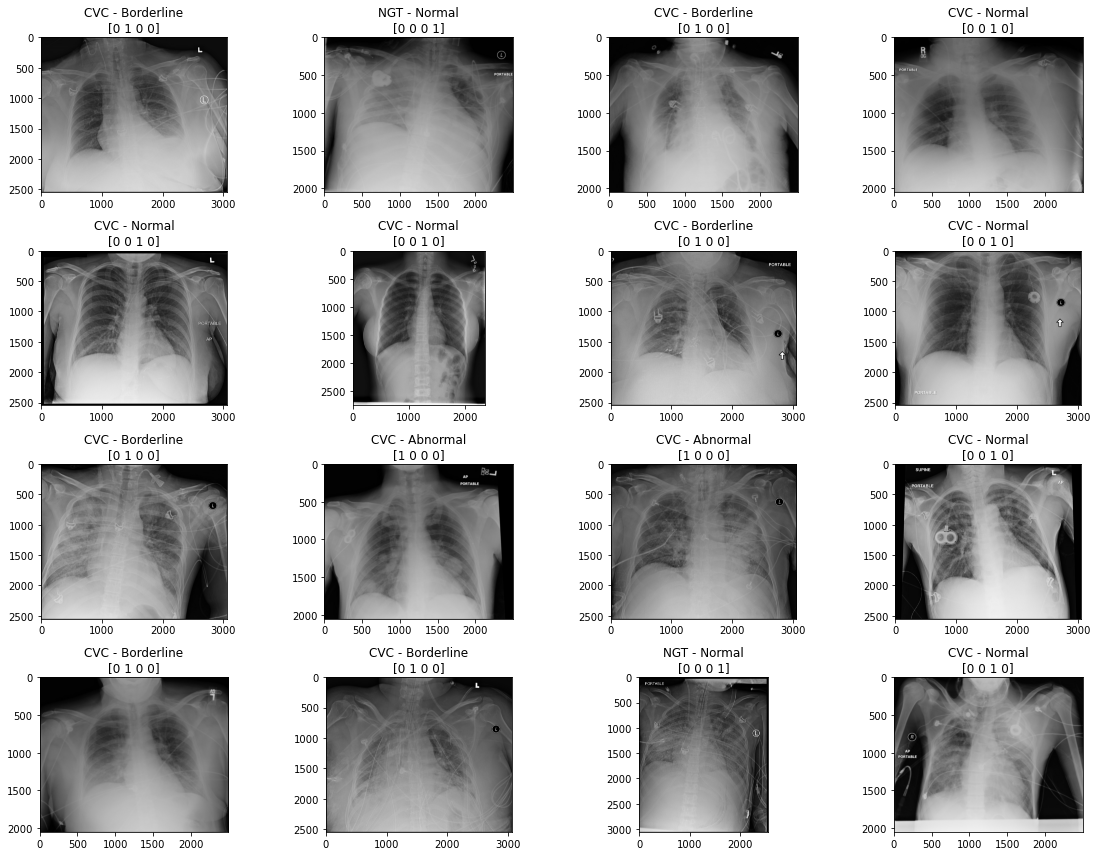

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from random import randint

tmp_train = data_image.sample(16)
image_ids = tmp_train["StudyInstanceUID"].values
label_ids = tmp_train["label"].values

lb_category = LabelBinarizer()
binarizer = lb_category.fit_transform(label_ids)

all_image(image_ids, label_ids, binarizer)

# 📊<span style="font-family:cursive;"> Display Data Plot Images</span>

In [ ]:
def plot_categorical(train, label_cols):
    fig = plt.figure(figsize = (15, 13), dpi = 300)
    plt.suptitle('Labels count', fontfamily = 'serif', size = 15)

    
    for ind, i in enumerate(label_cols):
        fig.add_subplot(4, 3, ind + 1)
        sns.countplot(data = train_df,
                      x = i,
                      #train[i], 
                      edgecolor = 'black',
                      palette = reversed(sns.color_palette('mako', 2)))
        
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(fontfamily = 'serif', size = 10)
        plt.yticks(fontfamily = 'serif', size = 10)
        plt.title(i, fontfamily = 'serif', size = 10)
    plt.show()

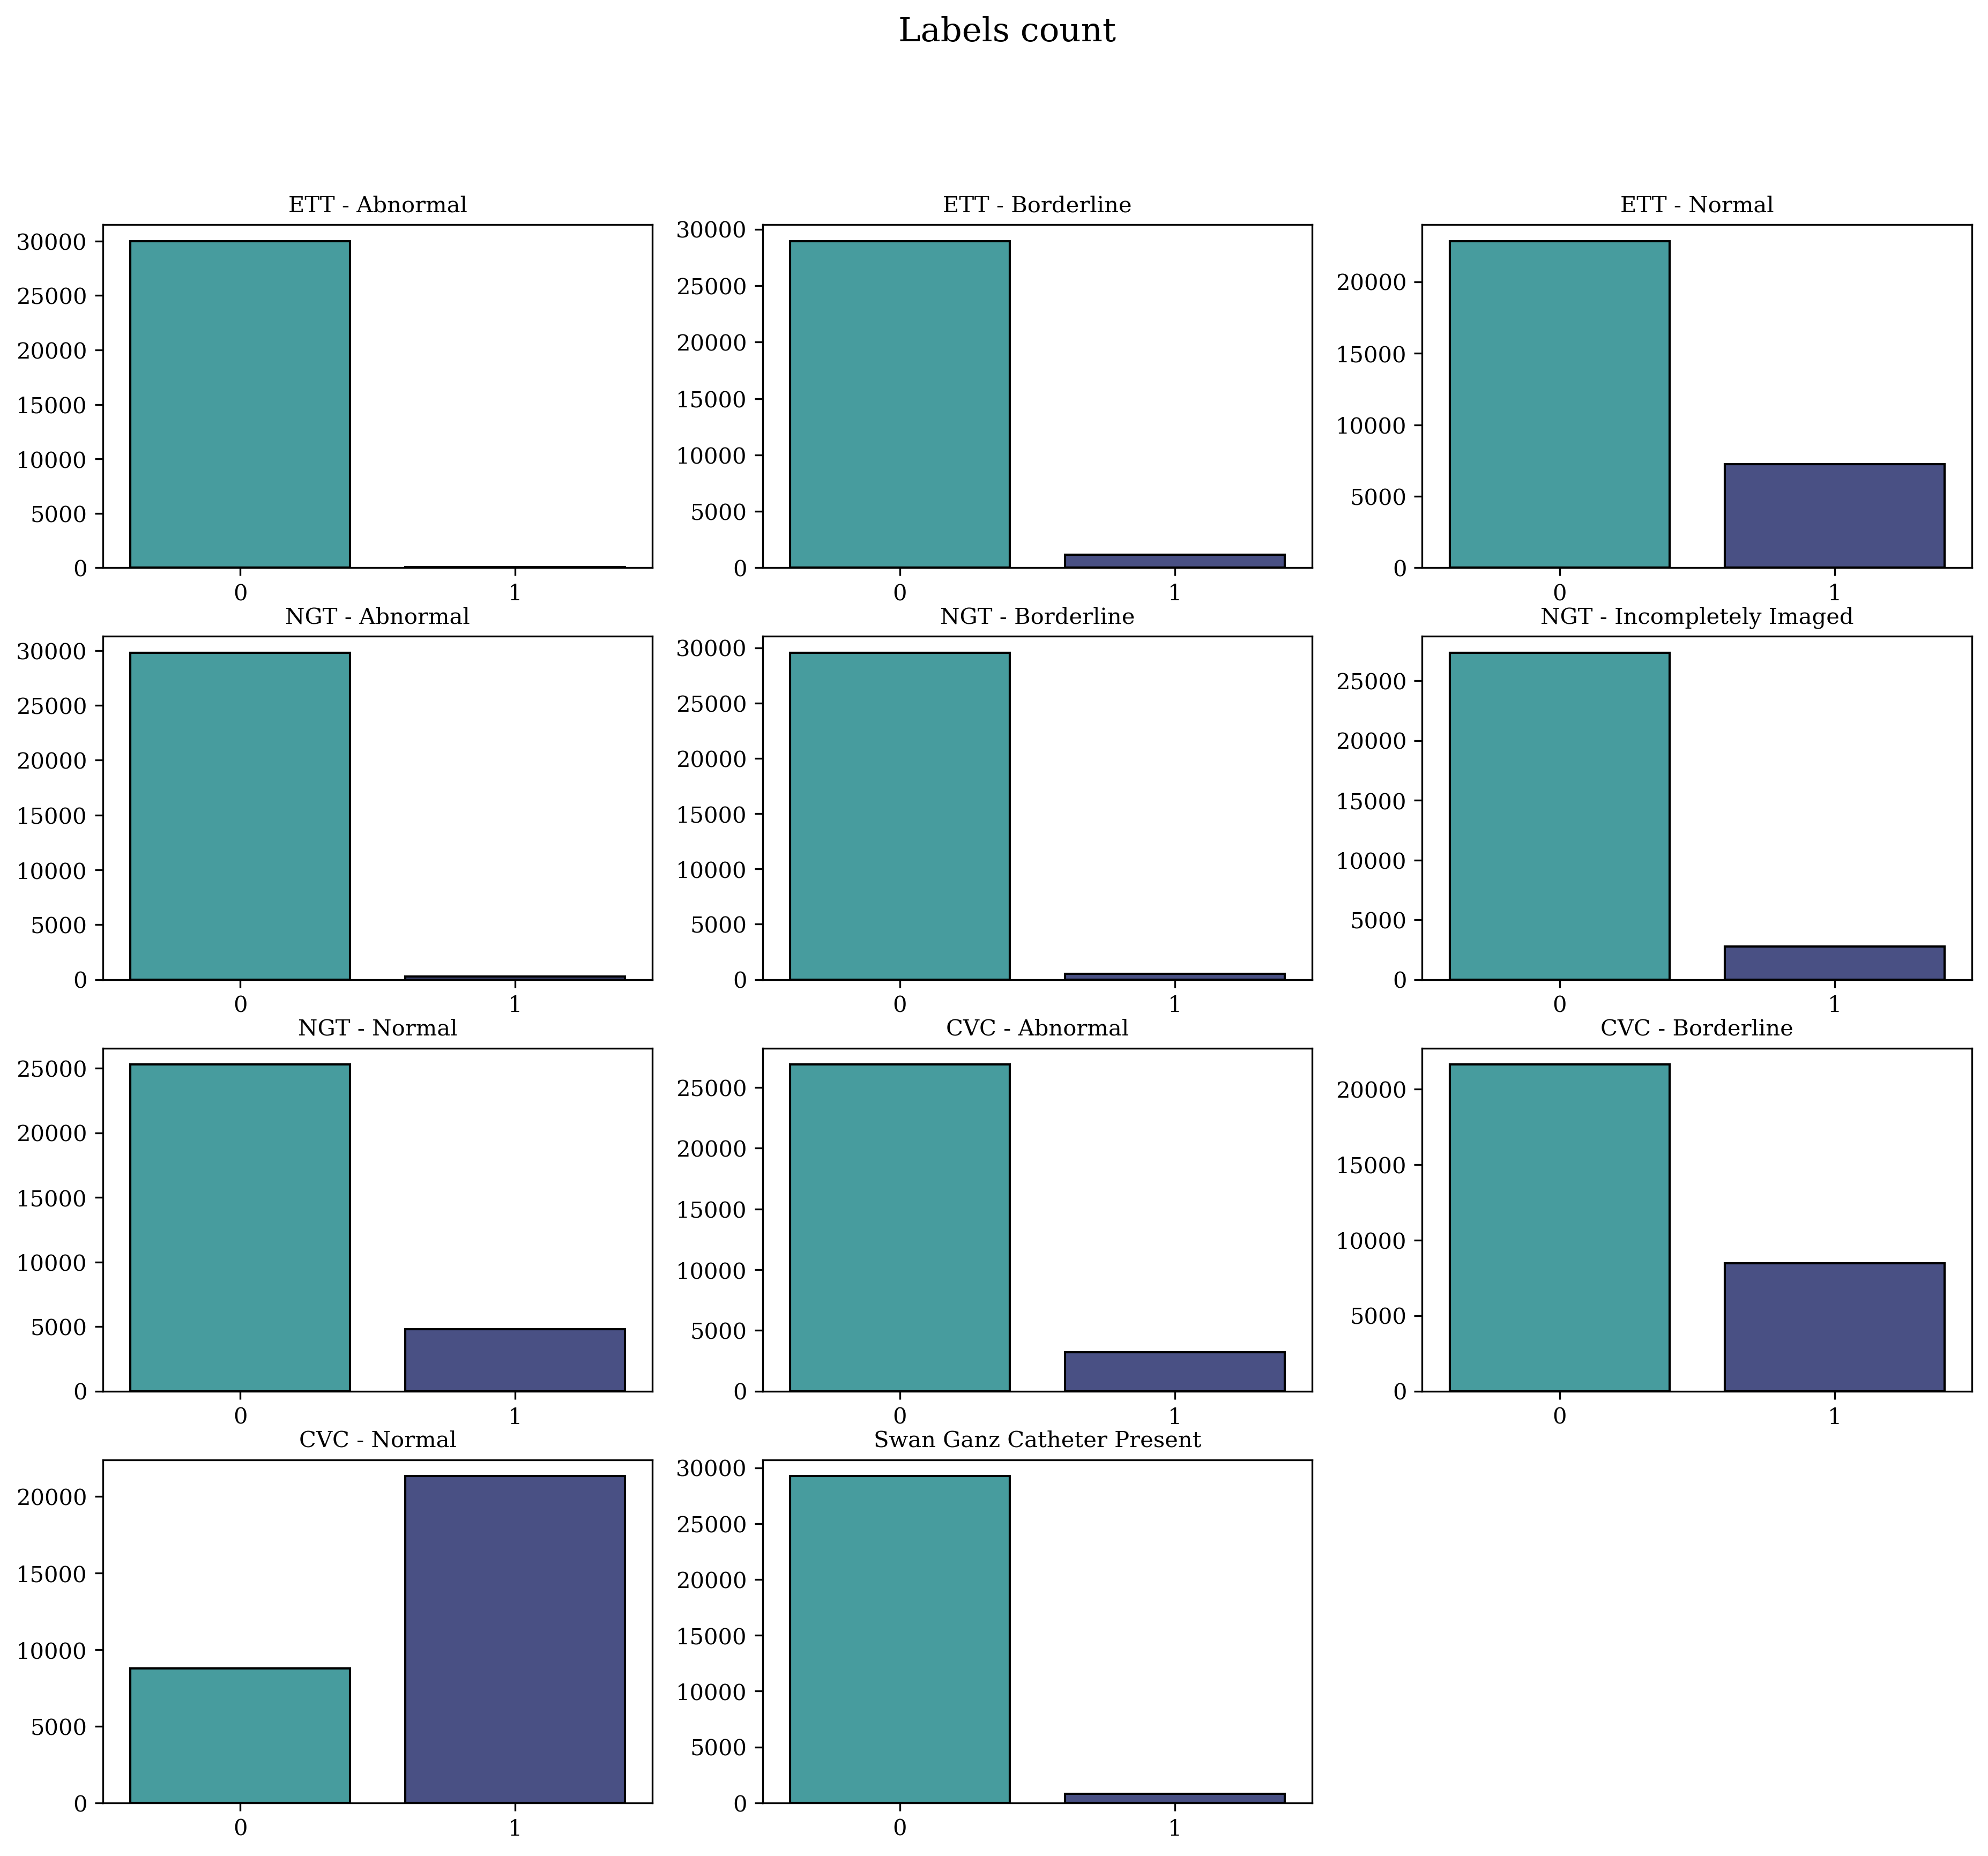

In [ ]:
plot_categorical(train,label_cols)

In [ ]:
'''
 TPU or GPU detection
 Detect hardware, return appropriate distribution strategy
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# 📗 <span style="font-family:cursive;"> Open CV - Augmentation</span>
**What is Data Augmentation?**
* Moving, rotating, cropping, flipping, changing color/brightness/hue and whatever else you can come up with to change the aspect of the original image. It is helpful in Overfitting, as the model learns not only 1 aspect of the image, but multiple (a cat can be standing up straight, or funny upside down, in a b&w image etc.)

**Other things to keep in mind**
* Different skin tones. Might need to find something that levels that.

*  Different lightings in the image.

* Different sizes of the images. We need to resize them.

In [ ]:
def NeedleAugmentation(image, n_needles=2, dark_needles=False, p=0.5, needle_folder='../input/xray-needle-augmentation'):
    
    '''
      Open CV - Based Custom Augmentation
    '''
    
    aug_prob = random.random()
    if aug_prob < p:
        height, width, _ = image.shape  # target image width and height
        needle_images = [im for im in os.listdir(needle_folder) if 'png' in im]

        for _ in range(1, n_needles):
            needle = cv2.cvtColor(cv2.imread(os.path.join(needle_folder, random.choice(needle_images))), cv2.COLOR_BGR2RGB)
            needle = cv2.flip(needle, random.choice([-1, 0, 1]))
            needle = cv2.rotate(needle, random.choice([0, 1, 2]))

            h_height, h_width, _ = needle.shape  # needle image width and height
            roi_ho = random.randint(0, abs(image.shape[0] - needle.shape[0]))
            roi_wo = random.randint(0, abs(image.shape[1] - needle.shape[1]))
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask 
            img2gray = cv2.cvtColor(needle, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of needle in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of insect from insect image.
            if dark_needles:
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                needle_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                needle_fg = cv2.bitwise_and(needle, needle, mask=mask)

            # Put needle in ROI and modify the target image
            dst = cv2.add(img_bg, needle_fg, dtype=cv2.CV_64F)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

    return image

In [ ]:
# Main parameters
BATCH_SIZE = 8 * REPLICAS
STEPS_PER_EPOCH = len(train_df) * 0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_df) * 0.2 / BATCH_SIZE
EPOCHS = 30
TARGET_SIZE = 750

In [ ]:
def build_decoder(with_labels = True,
                  target_size = (TARGET_SIZE, TARGET_SIZE), 
                  ext = 'jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels = 3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels = 3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels = True):
    def augment(img):
        img = NeedleAugmentation(img, n_needles=2, dark_needles=False, p=0.5)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels = None, bsize = 32, cache = True,
                  decode_fn = None, augment_fn = None,
                  augment = True, repeat = True, shuffle = 1024, 
                  cache_dir = ""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls = AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls = AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2

# Train test split
(train_img, valid_img, train_labels, valid_labels) = train_test_split(train_images, labels, train_size = 0.8, random_state = 0)

In [ ]:
# Tensorflow datasets
train_df = build_dataset(
     train_img, train_labels, bsize = BATCH_SIZE, 
     cache = True)

valid_df = build_dataset(
     valid_img, valid_labels, bsize = BATCH_SIZE, 
     repeat = False, shuffle = False, augment = False, 
     cache = True)

test_df = build_dataset(
    test_images, bsize = BATCH_SIZE, repeat = False, 
    shuffle = False, augment = False, cache = False)

# 🧪 <span style="font-family:cursive;"> Model Xception</span>
<img src="https://camo.githubusercontent.com/8fbdfc47b1575c45f4d2132b96f34826f2d913af/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313430302f312a684f6341456a39517a716742586377557a6d457653672e706e67" width="900">

In [ ]:
def create_model():
    conv_base = Xception(include_top = False, weights = 'imagenet',
                          input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dropout(0.25)(model)
    model = layers.Dense(11, activation = "sigmoid")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                   loss = "binary_crossentropy",
                   metrics = [tf.keras.metrics.AUC(multi_label = True)])
    return model

In [ ]:
with strategy.scope():
    model = create_model()
    
model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 750, 750, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 374, 374, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 374, 374, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 374, 374, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
print('Our Xception CNN has %d layers' %len(model.layers))

Our Xception CNN has 135 layers


In [ ]:
model_save = ModelCheckpoint('./Xcep_750_best_weights_TPU.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, 
                              patience = 2, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_df,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = valid_df,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/30
376/376 [==============================] - 1161s 3s/step - loss: 0.2607 - auc: 0.7388 - val_loss: 0.3550 - val_auc: 0.7336

Epoch 00001: val_loss improved from inf to 0.35495, saving model to ./Xcep_750_best_weights_TPU.h5
Epoch 2/30
376/376 [==============================] - 205s 545ms/step - loss: 0.2017 - auc: 0.8348 - val_loss: 0.1949 - val_auc: 0.8709

Epoch 00002: val_loss improved from 0.35495 to 0.19495, saving model to ./Xcep_750_best_weights_TPU.h5
Epoch 3/30
376/376 [==============================] - 204s 543ms/step - loss: 0.1818 - auc: 0.8721 - val_loss: 0.1932 - val_auc: 0.8895

Epoch 00003: val_loss improved from 0.19495 to 0.19319, saving model to ./Xcep_750_best_weights_TPU.h5
Epoch 4/30
376/376 [==============================] - 204s 544ms/step - loss: 0.1686 - auc: 0.8984 - val_loss: 0.1801 - val_auc: 0.9091

Epoch 00004: val_loss improved from 0.19319 to 0.18006, saving model to ./Xcep_750_best_weights_TPU.h5
Epoch 5/30
376/376 [==========================

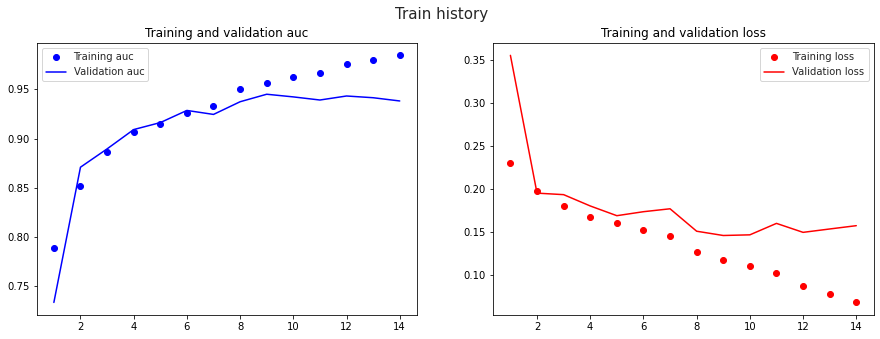

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('./Xception_750_TPU.h5')

# 🔎<span style="font-family:cursive;">Activations Layer Maps</span>
**So, what are activation anyway ?**
* At a simple level, activation functions help decide whether a neuron should be activated. This helps determine whether the information that the neuron is receiving is relevant for the input.   The activation function is a non-linear transformation that happens over an input signal, and the transformed output is sent to the next neuron.
* If you want to understand what precisely, these activations mean, and why are they placed in the neural net architecture in the first place, check out this article below this: 
* [](http://)[https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/](http://https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/)

In [ ]:
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
img_tensor = build_dataset(
    pd.Series(test_images[0]), bsize = 1,repeat = False, 
    shuffle = False, augment = False, cache = False)

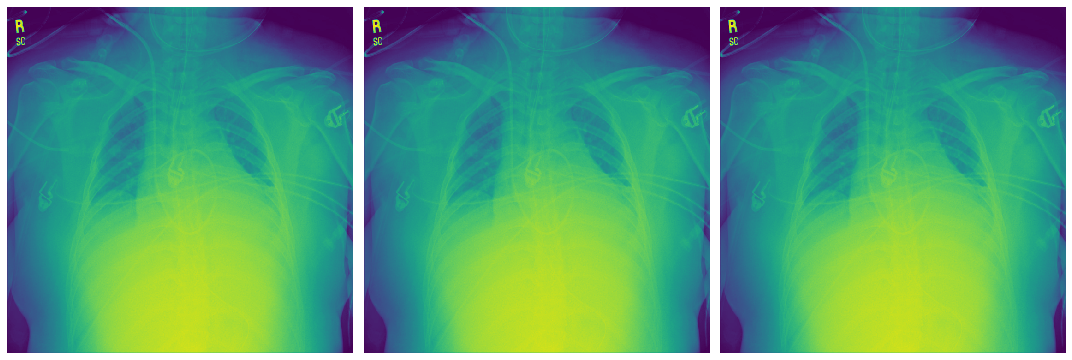

In [ ]:
activation_layer_vis(img_tensor)

In [ ]:
def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

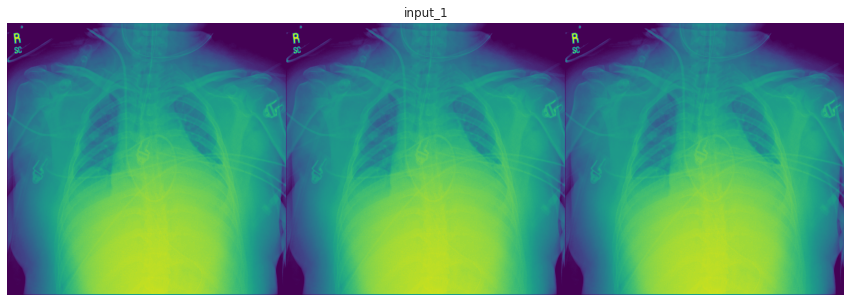

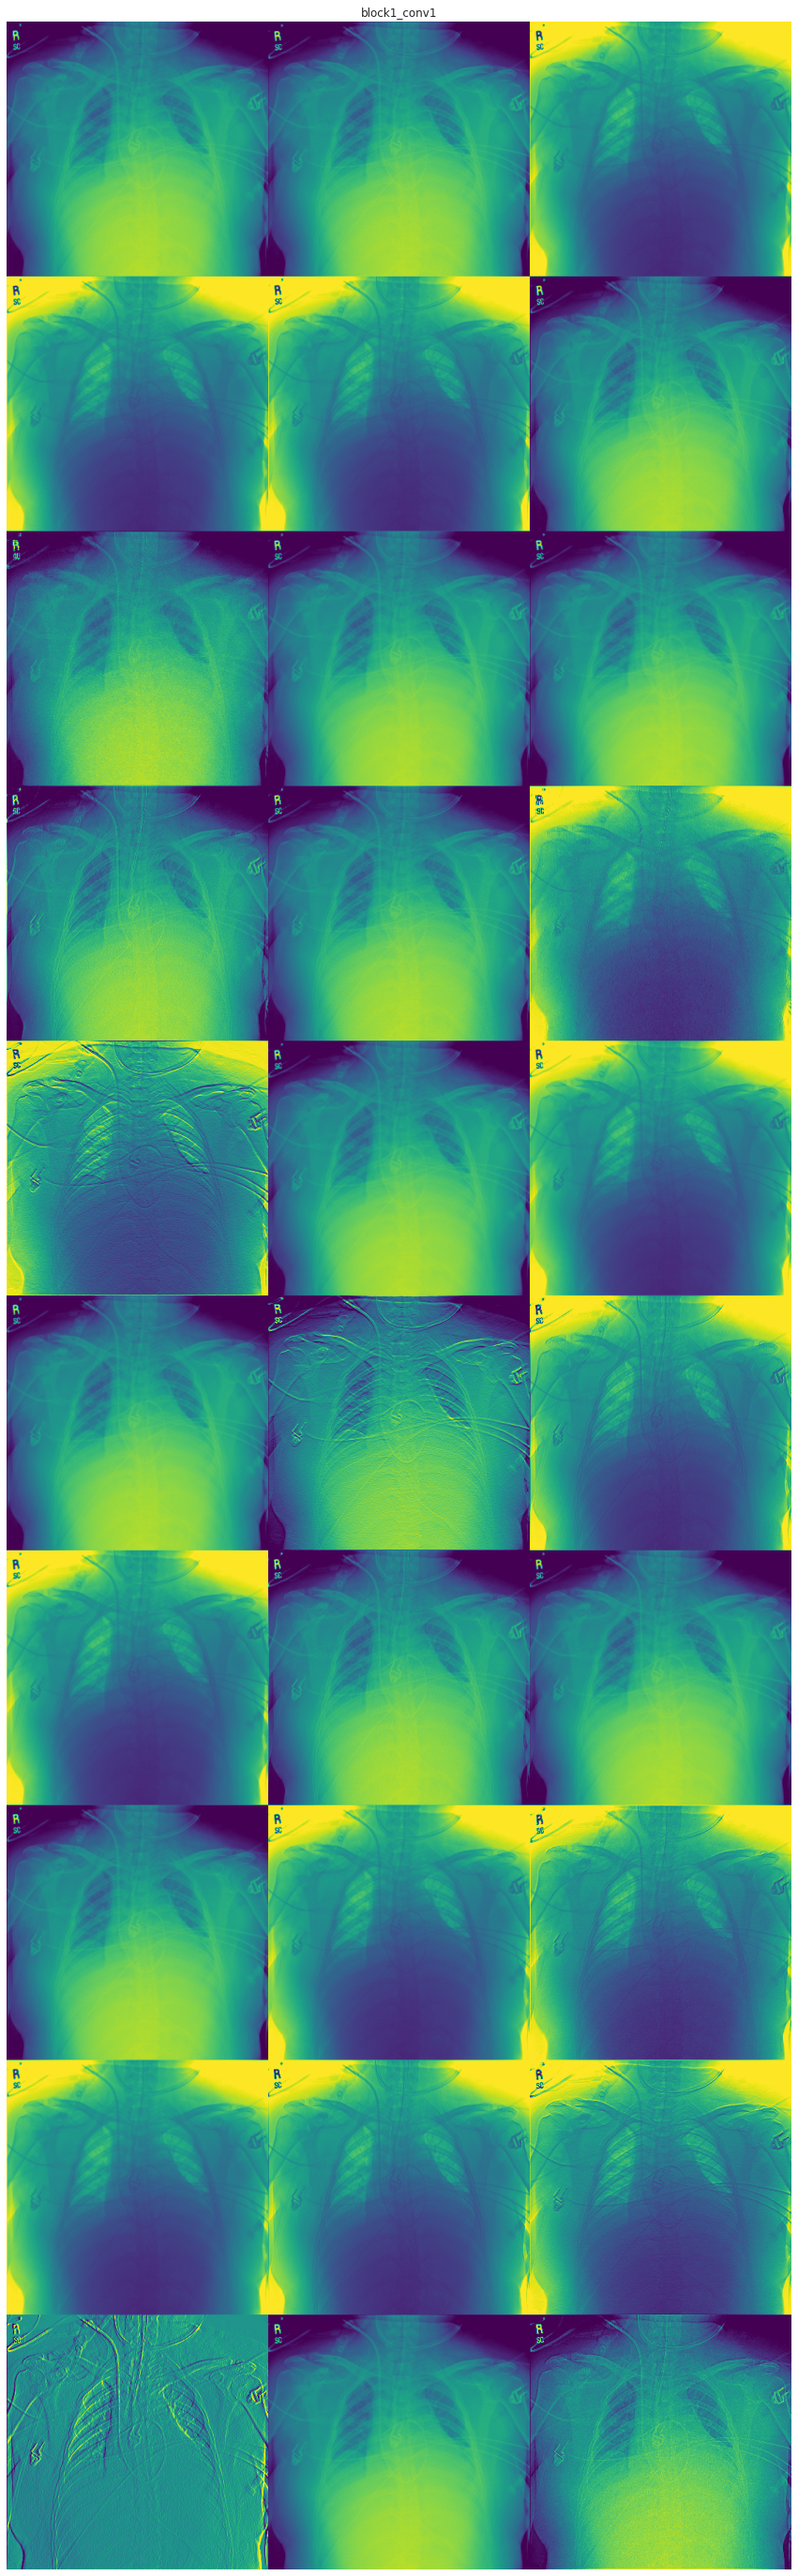

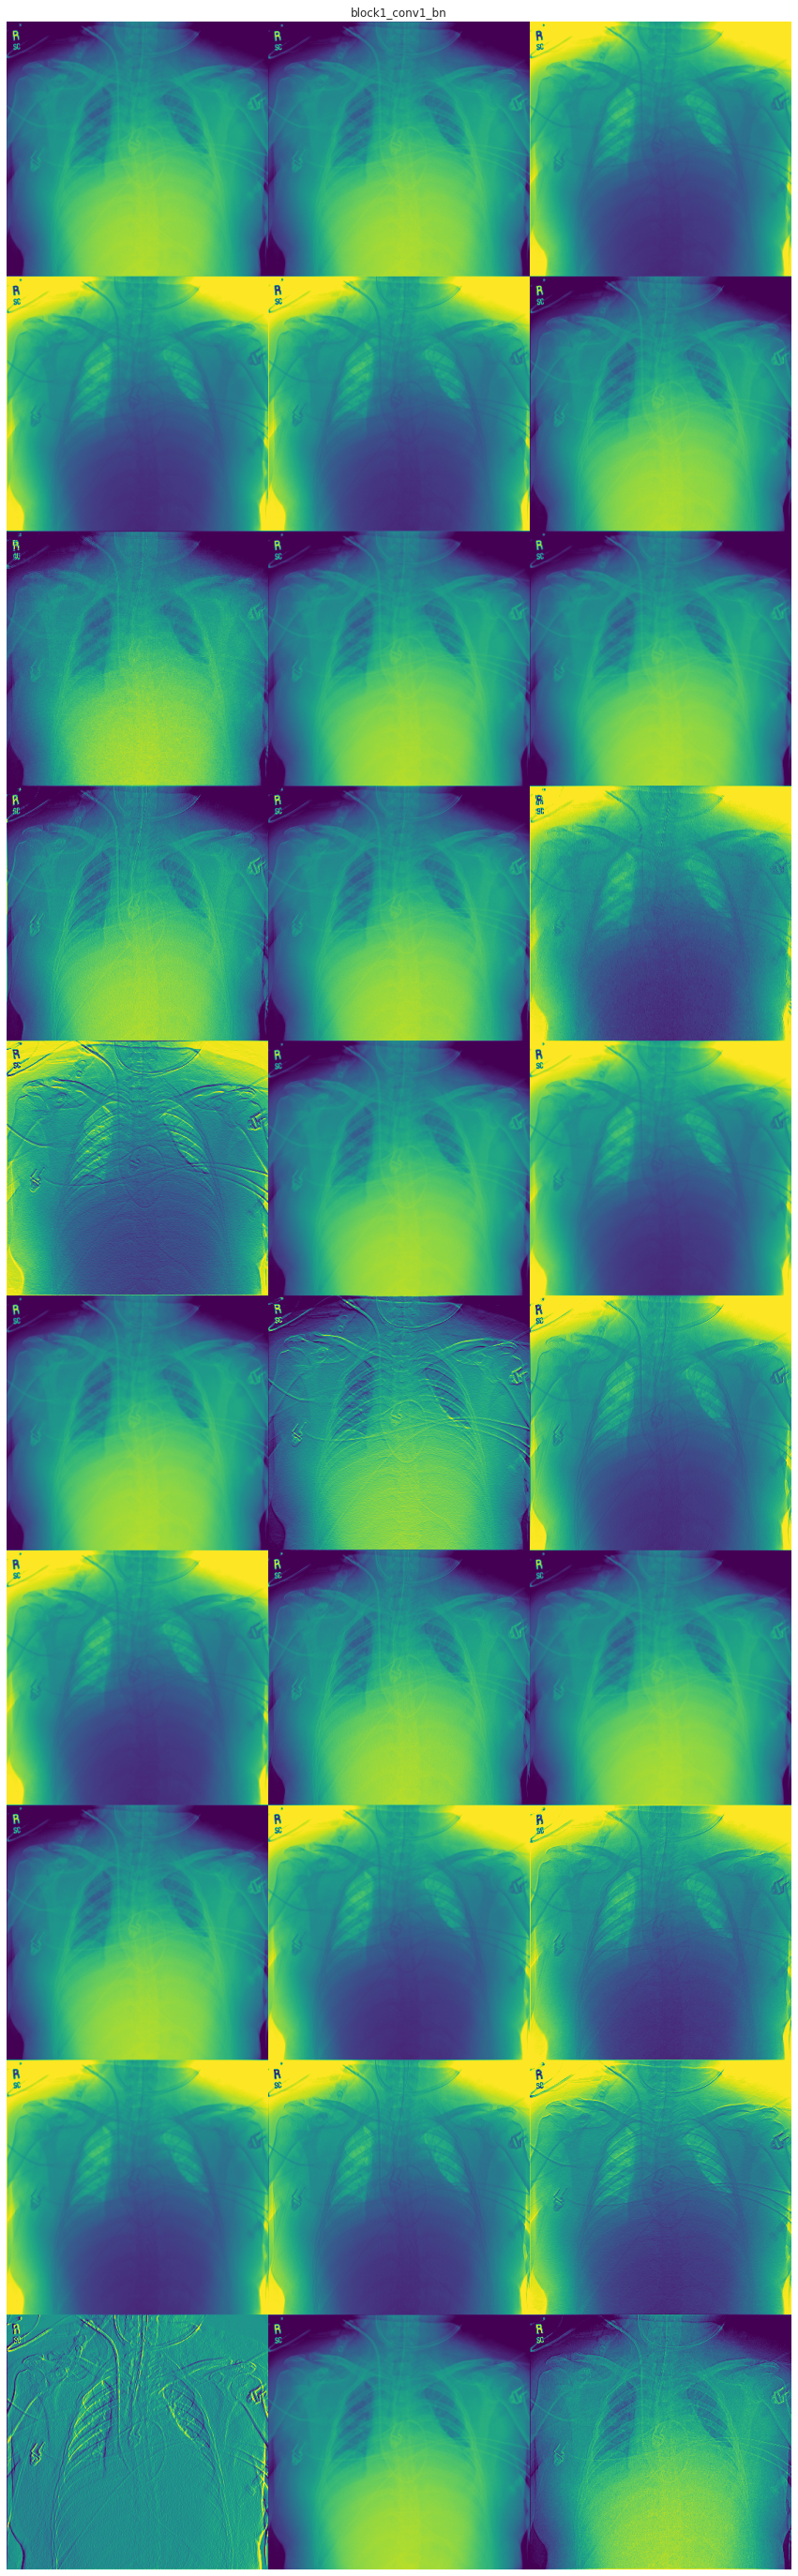

In [ ]:
all_activations_vis(img_tensor, 3)

**So here it is! Let’s try to interpret what’s going on:**

Reference : [https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0](http://https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0)

* The first layer is arguably retaining the full shape of the triangle, although there are several filters that are not activated and are left blank. At that stage, the activations retain almost all of the information present in the initial picture.

* As we go deeper in the layers, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as single borders, corners and angles. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.

* As mentioned above, the model stucture is overly complex to the point where we can see our last layers actually not activating at all, there’s nothing more to learn at that point.

In [ ]:
sub_df[label_cols] = model.predict(test_df, verbose = 1)
sub_df.to_csv('submission.csv', index = False)

56/56 [==============================] - 129s 2s/step


In [ ]:
sub_df.head()

StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.46923145579096002617...    1.855782e-02   
1  1.2.826.0.1.3680043.8.498.84006870182611080091...    2.980232e-08   
2  1.2.826.0.1.3680043.8.498.12219033294413119947...    1.490116e-07   
3  1.2.826.0.1.3680043.8.498.84994474380235968109...    2.855223e-02   
4  1.2.826.0.1.3680043.8.498.35798987793805669662...    3.343821e-04   

   ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0      4.886676e-01  5.486890e-01    1.855791e-04      2.417922e-03   
1      5.662441e-07  2.086163e-07    5.960464e-08      2.980232e-08   
2      1.609325e-06  0.000000e+00    3.635883e-06      2.682209e-07   
3      2.522045e-02  6.395042e-03    1.278741e-01      4.746503e-02   
4      1.423359e-04  2.020597e-05    3.983676e-04      5.312860e-04   

   NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  CVC - Borderline  \
0               1.942098e-03  9.956491e-01        0.020138          0.097743   
1               2.980232e-08  5.960464e-08        0.006371          0.002141   
2               0.000000e+00  0.000000e+00        0.001977          0.141211   
3               8.678288e-01  4.970032e-02        0.146781          0.230451   
4               6.741285e-05  2.453327e-04        0.006800          0.005463   

   CVC - Normal  Swan Ganz Catheter Present  
0      0.979668                1.000000e+00  
1      0.995460                3.874302e-07  
2      0.739828                3.904104e-06  
3      0.446973                3.158212e-03  
4      0.994967                2.247989e-04

## References :

Some references to notebooks were made in this notebook
* [https://www.kaggle.com/maksymshkliarevskyi/ranzcr-xception-tpu-prediction](http://www.kaggle.com/maksymshkliarevskyi/ranzcr-xception-tpu-prediction)
* [https://www.kaggle.com/khoongweihao/insect-augmentation-with-efficientdet-d6](http://www.kaggle.com/khoongweihao/insect-augmentation-with-efficientdet-d6)
* https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations
* https://arxiv.org/abs/1610.02357v3


# <span style="font-family:cursive;">If it's useful for you, come on upvote.Thank you for your attention 🙌</span>